In [1]:
import os, gc, pickle, datetime, scipy.sparse

import pandas as pd
import numpy as np

from sklearn.decomposition import TruncatedSVD, PCA

DATA_DIR = "/kaggle/input/open-problems-multimodal/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

In [2]:
%%time
train_target_df = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
train_input_df = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
test_input_df = pd.read_hdf(FP_CITE_TEST_INPUTS)

CPU times: user 39.6 s, sys: 8.23 s, total: 47.8 s
Wall time: 1min 29s


In [3]:
# drop multinome tech and change cell type to one hot vec 
meta_df = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
meta_df = meta_df.drop(meta_df[meta_df.technology == 'multiome'].index)
meta_df.drop(columns=['technology'],inplace=True)
cell_type_one_hot = pd.get_dummies(meta_df['cell_type'])
meta_df = meta_df.join(cell_type_one_hot)

# for train dataset
train_cell_index = train_input_df.index
train_meta_df = meta_df.reindex(train_cell_index)
train_meta_df.drop(columns=['day', 'donor','cell_type'],inplace=True) # drop donor and day columns

# for test dataset
test_cell_index = test_input_df.index
test_meta_df = meta_df.reindex(test_cell_index)
test_meta_df.drop(columns=['day', 'donor','cell_type'],inplace=True)

del meta_df

In [4]:
# some gene name include target protein so we need to keep those 
# but we don't want to use them in the dimension reduction that's why we need to drop them

protien = list(train_target_df.columns)
genes = list(train_input_df.columns)
gene_with_protien_columns = []
for i in genes:
    p = i.split('_')[1]
    if p in protien:
        gene_with_protien_columns.append(i)

print(len(gene_with_protien_columns))
print(protien)
# for training
train_protien_df = train_input_df[gene_with_protien_columns]
train_protien_df.to_pickle("/kaggle/working/train_with_target_protien.pkl") # pickle save 
train_input_df.drop(columns=gene_with_protien_columns, inplace=True)

# for testing
test_protien_df = test_input_df[gene_with_protien_columns]
test_protien_df.to_pickle("/kaggle/working/test_with_target_protien.pkl") # pickle save 
test_input_df.drop(columns=gene_with_protien_columns, inplace=True)

34
['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44', 'CD14', 'CD16', 'CD25', 'CD45RO', 'CD279', 'TIGIT', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5', 'CD195', 'CD32', 'CD196', 'CD185', 'CD103', 'CD69', 'CD62L', 'CD161', 'CD152', 'CD223', 'KLRG1', 'CD27', 'CD107a', 'CD95', 'CD134', 'HLA-DR', 'CD1c', 'CD11b', 'CD64', 'CD141', 'CD1d', 'CD314', 'CD35', 'CD57', 'CD272', 'CD278', 'CD58', 'CD39', 'CX3CR1', 'CD24', 'CD21', 'CD11a', 'CD79b', 'CD244', 'CD169', 'integrinB7', 'CD268', 'CD42b', 'CD54', 'CD62P', 'CD119', 'TCR', 'Rat-IgG1', 'Rat-IgG2a', 'CD192', 'CD122', 'FceRIa', 'CD41', 'CD137', 'CD163', 'CD83', 'CD124', 'CD13', 'CD2', 'CD226', 'CD29', 'CD303', 'CD49b', 'CD81', 'IgD', 'CD18', 'CD28', 'CD38', 'CD127', 'CD45', 'CD22', 'CD71', 'CD26', 'CD115', 'CD63',

In [5]:
train_input_df
test_input_df

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
c2150f55becb,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,4.090185,0.000000
65b7edf8a4da,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
c1b26cb1057b,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.000000,0.0,0.00000,3.847321,3.847321,0.000000
917168fa6f83,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.000000,0.0,0.00000,3.436846,4.113780,0.000000
2b29feeca86d,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.000000,0.0,3.51861,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a9b4d99f1f50,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.719836,...,0.000000,0.000000,0.000000,3.719836,0.000000,0.0,0.00000,0.000000,3.719836,0.000000
0e2c1d0782af,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.026206,0.000000,...,4.026206,0.000000,0.000000,4.026206,0.000000,0.0,0.00000,0.000000,4.710393,0.000000
a3cbc5aa0ec3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.306634,0.000000,0.000000,0.0,0.00000,4.306634,6.933096,4.993019


In [6]:
# find all the columns' value are zero and drop
all_zero_columns = list(train_input_df.columns[(train_input_df == 0).all()])
train_input_df.drop(columns=all_zero_columns, inplace=True)
train_input_df.to_pickle("/kaggle/working/non_zero_train_input.pkl") # pickle save
train_input_df

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


In [7]:
all_zero_columns = list(test_input_df.columns[(test_input_df == 0).all()])
test_input_df.drop(columns=all_zero_columns, inplace=True)
test_input_df.to_pickle("/kaggle/working/non_zero_test_input.pkl")
test_input_df

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,ENSG00000115977_AAK1,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
c2150f55becb,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,4.090185,0.000000
65b7edf8a4da,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.039545,...,0.000000,0.000000,0.000000,4.039545,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
c1b26cb1057b,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.000000,0.0,0.00000,3.847321,3.847321,0.000000
917168fa6f83,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,4.513782,...,3.436846,0.000000,4.113780,5.020215,0.000000,0.0,0.00000,3.436846,4.113780,0.000000
2b29feeca86d,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.000000,0.0,3.51861,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a9b4d99f1f50,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.719836,0.000000,...,0.000000,0.000000,0.000000,3.719836,0.000000,0.0,0.00000,0.000000,3.719836,0.000000
0e2c1d0782af,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.026206,0.000000,0.000000,...,4.026206,0.000000,0.000000,4.026206,0.000000,0.0,0.00000,0.000000,4.710393,0.000000
a3cbc5aa0ec3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.306634,0.000000,0.000000,0.0,0.00000,4.306634,6.933096,4.993019


In [8]:
# reindex the target df
train_target_df = train_target_df.reindex(train_cell_index)

In [9]:
# send the input_df into sparse
train_input = scipy.sparse.csr_matrix(train_input_df.values)
test_input = scipy.sparse.csr_matrix(test_input_df.values)

In [10]:
gc.collect()

0

In [21]:
%%time
## Train Dataset
# either SVD or PCA and don't run both of them in case overfiting
# tSVD compress to 512 dimension
print(f"Shape of both before tSVD: {train_input.shape}")
svd = TruncatedSVD(n_components=512, random_state=1) 
train_input_tsvd = svd.fit_transform(train_input)
print(f"Shape of both after tSVD:  {train_input_tsvd.shape}")

Shape of both before tSVD: (70988, 21567)
Shape of both after tSVD:  (70988, 512)
CPU times: user 41min 23s, sys: 13 s, total: 41min 36s
Wall time: 41min 12s


In [26]:
file_obj = open("/kaggle/working/svd.p", "wb") 
pickle.dump(svd, file_obj)
# To load again
with open("/kaggle/working/svd.p", 'rb') as file:
    # Load the pickled object
    svd = pickle.load(file)

In [27]:
%%time
## Test Dataset
print(f"Shape of both before tSVD: {test_input.shape}")
svd_model = TruncatedSVD(n_components=512, random_state=1) 
test_input_tsvd = svd_model.fit_transform(test_input)
print(f"Shape of both after tSVD:  {test_input_tsvd.shape}")

Shape of both before tSVD: (48663, 21271)
Shape of both after tSVD:  (48663, 512)
CPU times: user 27min 44s, sys: 10.1 s, total: 27min 54s
Wall time: 27min 34s


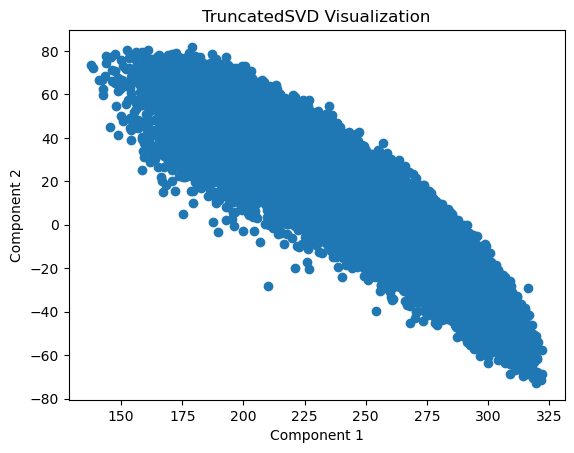

In [40]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(train_input_tsvd[:, 0], train_input_tsvd[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('TruncatedSVD Visualization')
plt.show()

In [29]:
X = np.hstack([train_input_tsvd, train_protien_df.values, train_meta_df.values])
# also need to join with the metadata_df
np.save('/kaggle/working/cite_train_X.npy', X)

In [30]:
train_target_df.to_hdf('/kaggle/working/cite_train_y.h5',key='df', mode='w')

In [31]:
X_test = np.hstack([test_input_tsvd, test_protien_df.values, test_meta_df.values])
np.save('/kaggle/working/cite_test_X.npy', X_test)

In [36]:
import json
json_object = json.dumps(gene_with_protien_columns)
with open("/kaggle/working/gene_with_protien_columns.json", "w") as outfile:
    outfile.write(json_object)

In [42]:
! zip -r process_data.zip .

  adding: cite_train_X.npy (deflated 12%)
  adding: gene_with_protien_columns.json (deflated 69%)
  adding: __notebook_source__.ipynb (deflated 44%)
  adding: .virtual_documents/ (stored 0%)
  adding: svd.p (deflated 6%)
  adding: train_with_target_protien.pkl (deflated 71%)
  adding: cite_test_X.npy (deflated 12%)
  adding: cite_train_y.h5 (deflated 8%)
  adding: non_zero_test_input.pkl (deflated 77%)
  adding: non_zero_train_input.pkl (deflated 78%)
  adding: test_with_target_protien.pkl (deflated 70%)
